# Prototyping notebook for future version

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage

from pathlib import Path
from pyref import pyref
import polars as pl

# import pyref as rf

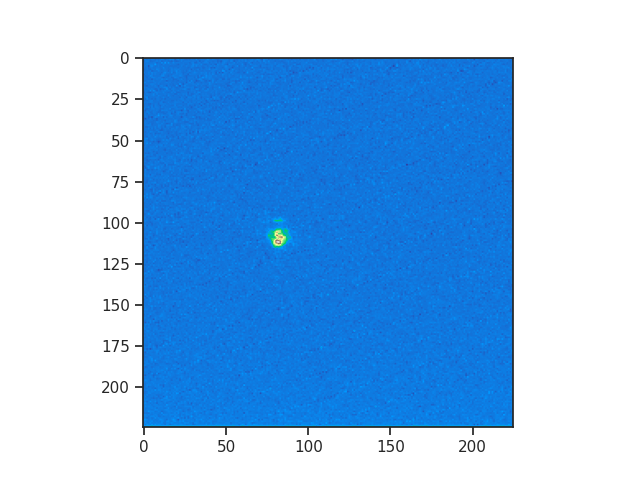

In [2]:
from pyref.loader import PrsoxrLoader

loader = PrsoxrLoader(Path.home() / "projects/pyref/test/190.0")
loader.mask_image()

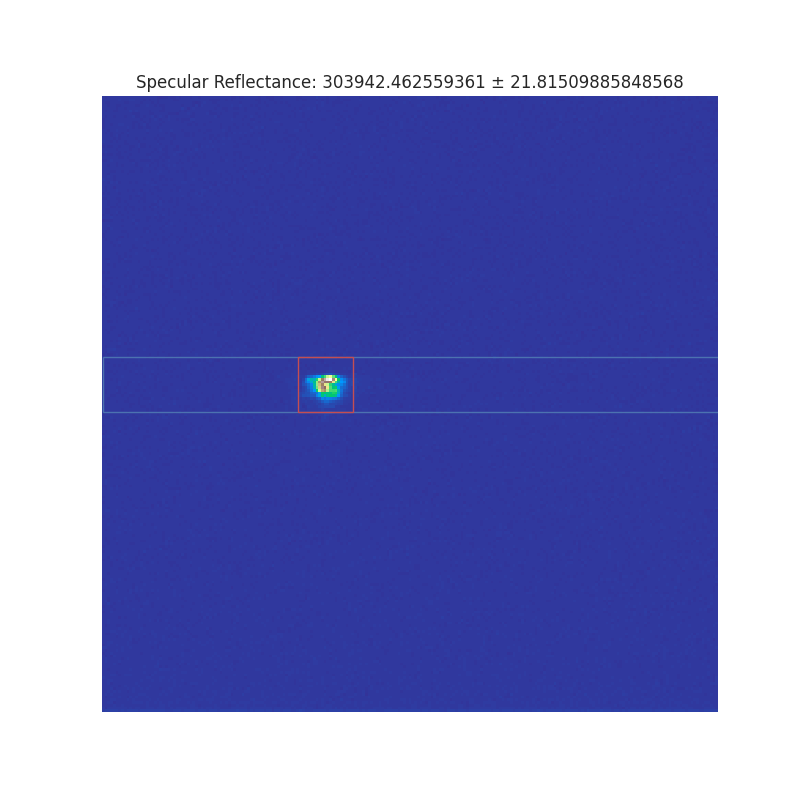

In [3]:
loader.check_spot()

In [4]:
img = loader.meta[15].select("Raw").to_numpy()[0][0]

In [5]:
refl = loader()

shape: (170, 8)
┌─────────┬─────────────┬────────────┬────────────┬────────────┬──────────┬───────────┬────────────┐
│ θ [deg] ┆ I [arb.     ┆ δI [arb.   ┆ I₀ [arb.   ┆ δI₀ [arb.  ┆ Q [Å⁻¹]  ┆ r [a. u.] ┆ δr [a. u.] │
│ ---     ┆ un.]        ┆ un.]       ┆ un.]       ┆ un.]       ┆ ---      ┆ ---       ┆ ---        │
│ f64     ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ f64      ┆ f64       ┆ f64        │
│         ┆ f64         ┆ f64        ┆ f64        ┆ f64        ┆          ┆           ┆            │
╞═════════╪═════════════╪════════════╪════════════╪════════════╪══════════╪═══════════╪════════════╡
│ 0.0     ┆ 3.0432e8    ┆ 21895.4146 ┆ 4.8933e8   ┆ 8938.76509 ┆ 0.0      ┆ 0.621907  ┆ 0.000059   │
│         ┆             ┆ 84         ┆            ┆ 1          ┆          ┆           ┆            │
│ 0.0     ┆ 5.1746e8    ┆ 21895.4119 ┆ 4.8933e8   ┆ 8938.76509 ┆ 0.0      ┆ 1.05748   ┆ 0.000047   │
│         ┆             ┆ 49         ┆            ┆ 1          ┆          ┆

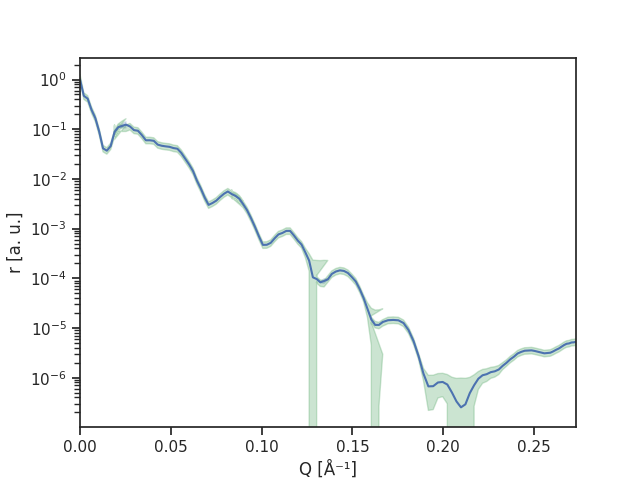

In [6]:
loader.plot_data()
plt.show()

In [25]:
refl.write_csv("test.csv")

# Fitting

In [74]:
from pypxr.structure import PXR_MaterialSLD, PXR_SLD, PXR_Structure
from pypxr.reflectivity import PXR_ReflectModel
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
import json
import periodictable.xsf as xsf
from pyref.fitting.logp import LogpExtra

In [75]:
q = refl.select("Q [Å⁻¹]").to_numpy()[:, 0]
r = refl.select("r [a. u.]").to_numpy()[:, 0]
e = refl.select("δr [a. u.]").to_numpy()[:, 0]
xe = np.zeros_like(e)
dataset = ReflectDataset(np.vstack((q, r)))

In [105]:
# def n(compound: str, energy: float, density: float) -> compile:
#     energy_keV = 1e-3 * energy
#     n = xsf.index_of_refraction(compound, energy=energy_keV, density=density)
#     delta = 1 - np.real(n)
#     beta = -np.imag(n)
#     n = 1 - (1j * beta + delta)
#     return n


with open("ZnPc_RoomTemp.json") as f:
    znpc_mono_struct_file = json.load(f)

en = loader.meta.select("Beamline Energy [eV]").to_numpy()[0][0]

vac = PXR_MaterialSLD("", 0, en)(0, 0)
si = PXR_MaterialSLD("Si", 2.3, en, name="Si")(0, 10)
sio2 = PXR_MaterialSLD("SiO2", 1.6, en, name="SiO2")(
    znpc_mono_struct_file["SiO2"]["thickness"],
    znpc_mono_struct_file["SiO2"]["roughness"],
)
c_amor = PXR_MaterialSLD("C", 1.6, en, name="C_Amorphous")(
    znpc_mono_struct_file["C"]["thickness"], znpc_mono_struct_file["C"]["roughness"]
)

znpc_surf = PXR_SLD(
    (-0.001430114353418879 + 0.000532924066606992j), symmetry="uni", name="ZnPc_surface"
)(
    znpc_mono_struct_file["C32H16N8Zn"]["thickness"] * 0.1,
    znpc_mono_struct_file["C32H16N8Zn"]["roughness"] * 0.1,
)

znpc = PXR_SLD(
    (-0.001430114353418879 + 0.000532924066606992j), symmetry="uni", name="ZnPc"
)(
    znpc_mono_struct_file["C32H16N8Zn"]["thickness"] * 0.8,
    znpc_mono_struct_file["C32H16N8Zn"]["roughness"] * 0.8,
)

znpc_inter = PXR_SLD(
    (-0.001430114353418879 + 0.000532924066606992j),
    symmetry="uni",
    name="ZnPc_interface",
)(
    znpc_mono_struct_file["C32H16N8Zn"]["thickness"] * 0.1,
    znpc_mono_struct_file["C32H16N8Zn"]["roughness"] * 0.1,
)

In [106]:
znpc.thick.setp(vary=True, bounds=(190, 210))

znpc.sld.xx.setp(vary=True, bounds=(-0.001, 0.001))
znpc.sld.zz.setp(vary=True, bounds=(-0.002, -0.005))

znpc.sld.ixx.setp(vary=True, bounds=(0, 0.002))
znpc.sld.izz.setp(vary=True, bounds=(0, 0.002))

znpc_inter.thick.setp(vary=True, bounds=(0, 20))
znpc_inter.rough.setp(vary=True, bounds=(0, 20))

znpc_inter.sld.xx.setp(vary=True, bounds=(-0.001, 0.001))
znpc_inter.sld.zz.setp(vary=True, bounds=(-0.002, -0.005))

znpc_surf.thick.setp(vary=True, bounds=(0, 20))
znpc_surf.rough.setp(vary=True, bounds=(0, 20))

znpc_surf.sld.xx.setp(vary=True, bounds=(-0.001, 0.001))
znpc_surf.sld.zz.setp(vary=True, bounds=(-0.002, -0.005))

c_amor.sld.density.setp(vary=True, bounds=(1, 2.5))

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1          , bounds=[0.6, 1.1]>
<Parameter:     'bkg'     , value=0          , bounds=[1e-09, 1e-06]>
<Parameter:'ZnPc_surface_thick', value=19.6442 +/- 0.0377, bounds=[0.0, 20.0]>
<Parameter:'ZnPc_surface_xx', value=-0.000364356 +/- 0.000595, bounds=[-0.001, 0.001]>
<Parameter:'ZnPc_surface_zz', value=-0.00260823 +/- 0.000944, bounds=[-0.005, -0.002]>
<Parameter:'ZnPc_surface_rough', value=0.721666 +/- 0.00147, bounds=[0.0, 20.0]>
<Parameter: 'ZnPc_thick'  , value=200.332 +/- 5.46 , bounds=[190.0, 210.0]>
<Parameter:   'ZnPc_xx'   , value=0.000498368 +/- 0.000579, bounds=[-0.001, 0.001]>
<Parameter:  'ZnPc_ixx'   , value=0.000532941 +/- 8.99e-07, bounds=[0.0, 0.002]>
<Parameter:   'ZnPc_zz'   , value=-0.00360455 +/- 0.000943, bounds=[-0.005, -0.002]>
<Parameter:  'ZnPc_izz'   , value=0.00053293 +/- 9.06e-07, bounds=[0.0, 0.002]>
<Parameter:'ZnP

(<Figure size 640x480 with 1 Axes>, <Axes: >)

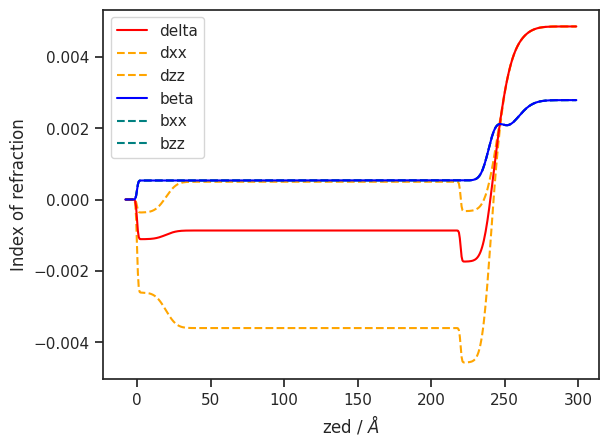

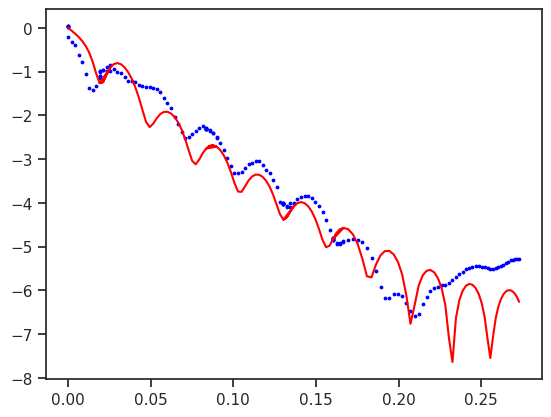

In [110]:
struct = vac | znpc_surf | znpc | znpc_inter | c_amor | sio2 | si
struct.plot()

model = PXR_ReflectModel(struct, pol="p", scale=1, bkg=0, dq=0, energy=en)
model.scale.setp(vary=True, bounds=(0.6, 1.1))
model.bkg.setp(vary=True, bounds=(1e-9, 1e-6))


objective = Objective(model, dataset, transform=Transform("logY"))
objective.logp_extra = LogpExtra(objective)
print(objective.varying_parameters())
objective.plot()

  0%|          | 0/20 [00:00<?, ?it/s]/home/hduva/projects/pyref/.venv/lib/python3.12/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.851435 +/- 8.68e-05, bounds=[0.6, 1.1]>
<Parameter:     'bkg'     , value=5.04387e-07 +/- 5.01e-11, bounds=[1e-09, 1e-06]>
<Parameter:'ZnPc_surface_thick', value=10.1152 +/- 0.00101, bounds=[0.0, 20.0]>
<Parameter:'ZnPc_surface_xx', value=-4.06362e-06 +/- 4.16e-10, bounds=[-0.001, 0.001]>
<Parameter:'ZnPc_surface_zz', value=-0.00350222 +/- 3.61e-07, bounds=[-0.005, -0.002]>
<Parameter:'ZnPc_surface_rough', value=9.8913 +/- 0.00101, bounds=[0.0, 20.0]>
<Parameter: 'ZnPc_thick'  , value=200.018 +/- 0.02 , bounds=[190.0, 210.0]>
<Parameter:   'ZnPc_xx'   , value=-2.11244e-06 +/- 2.06e-10, bounds=[-0.001, 0.001]>
<Parameter:  'ZnPc_ixx'   , value=0.00100307 +/- 1.01e-07, bounds=[0.0, 0.002]>
<Parameter:   'ZnPc_zz'   , value=-0.00350309 +/- 3.54e-07, bounds=[-0.005, -0.002]>
<Parameter:  'ZnPc_izz'   , value=0.000991162 +/- 9.95e-08, bounds=[0.0, 

(<Figure size 640x480 with 1 Axes>, <Axes: >)

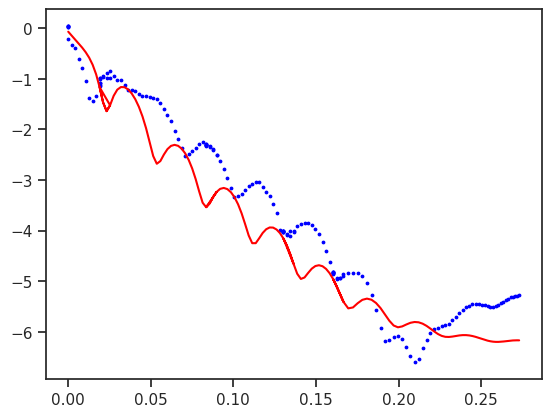

In [112]:
move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
nwalkers = 200
nsteps = 200
random_state = 1

fitter_1 = CurveFitter(objective, nwalkers=nwalkers, moves=move)
fitter_1.initialise("jitter")
fitter_1.sample(nsteps, random_state=random_state)

print(objective.varying_parameters())

objective.plot()

In [87]:
znpc.sld.tensor.trace() / 3

(-0.001430114353418879+0.000532924066606992j)

Text(0, 0.5, 'log posterior')

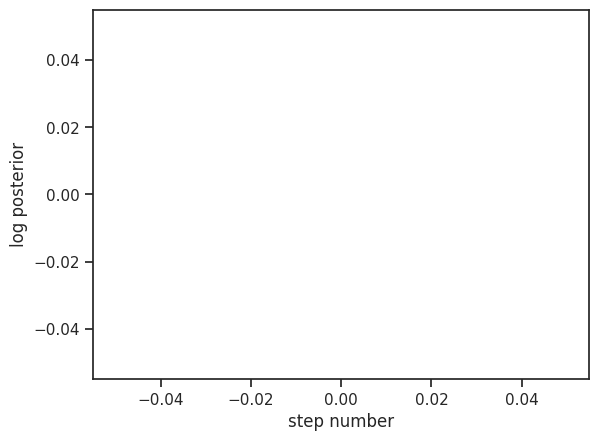

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
lp1 = fitter_1.logpost
fig, ax = plt.subplots()
ax.plot(-lp1)
ax.set_xlabel('step number')
ax.set_ylabel('log posterior')